In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colormath.color_objects import sRGBColor, LabColor, AdobeRGBColor, XYZColor
from colormath.color_conversions import convert_color
from skimage import io, color
import skimage
import itertools

import sys
import os
sys.path.append('/home/timothy/allen/Functions/')  # Add the directory to the system path

import linear_transformation_functions as mf

import skimage.color
from scipy.spatial import ConvexHull

In [2]:
%%bash

cd /home/timothy/allen/other_hierarchies

Plotting colors in 3D space
- Loading in ALLEN colors
- Loading in my generated colors
- Plotting the colors in LAB space

[[ 53.08323116 -24.54621638 -10.87504743]
 [ 31.68375049  19.07052327  38.18328329]
 [ 16.7409008   26.41609996 -60.84740238]
 [ 36.38708541  63.21908967 -31.33930205]
 [  6.98897047 -14.50337408   9.61617819]
 [ 87.76229049  10.35797299  -1.95012745]
 [  4.56289487  19.66106436   7.00035203]]
RGB Color Coordinates:
sRGBColor (rgb_r:0.2221 rgb_g:0.5452 rgb_b:0.5669)
sRGBColor (rgb_r:0.4331 rgb_g:0.2423 rgb_b:0.0356)
sRGBColor (rgb_r:0.0000 rgb_g:0.1186 rgb_b:0.5183)
sRGBColor (rgb_r:0.6210 rgb_g:0.0054 rgb_b:0.5403)
sRGBColor (rgb_r:0.0000 rgb_g:0.1066 rgb_b:0.0041)
sRGBColor (rgb_r:0.9357 rgb_g:0.8369 rgb_b:0.8790)
sRGBColor (rgb_r:0.1613 rgb_g:0.0014 rgb_b:0.0025)


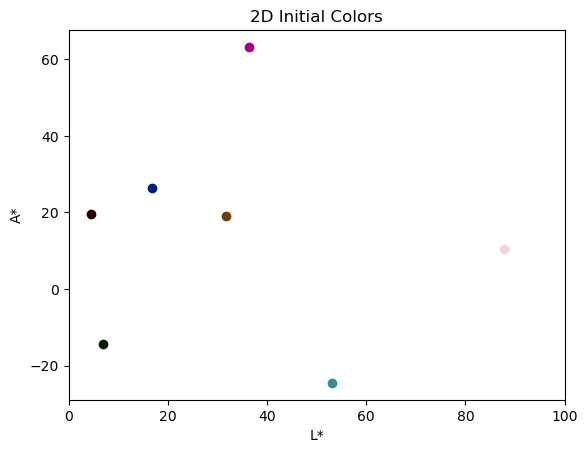

RGB Color Coordinates:
[LabColor(lab_l=53.08323115727585,lab_a=-24.54621637678417,lab_b=-10.875047432080255), LabColor(lab_l=31.683750486423243,lab_a=19.07052327214098,lab_b=38.18328329492397), LabColor(lab_l=16.740900802686177,lab_a=26.41609995699795,lab_b=-60.84740238344961), LabColor(lab_l=36.387085405804186,lab_a=63.21908967451792,lab_b=-31.33930205143719), LabColor(lab_l=6.988970471556758,lab_a=-14.5033740805771,lab_b=9.616178191519948), LabColor(lab_l=87.76229048847819,lab_a=10.357972990133357,lab_b=-1.95012745026939), LabColor(lab_l=4.562894874807672,lab_a=19.66106435774266,lab_b=7.000352025490675)]
<class 'list'>


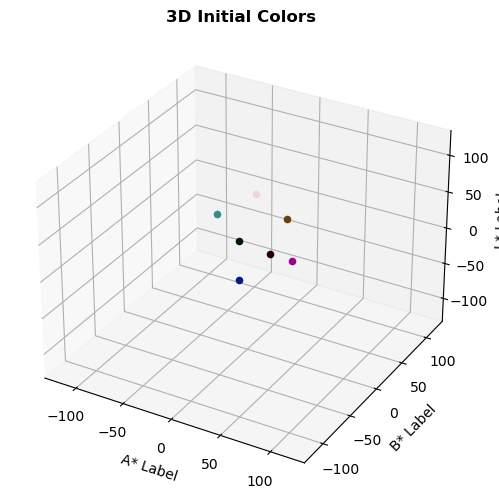

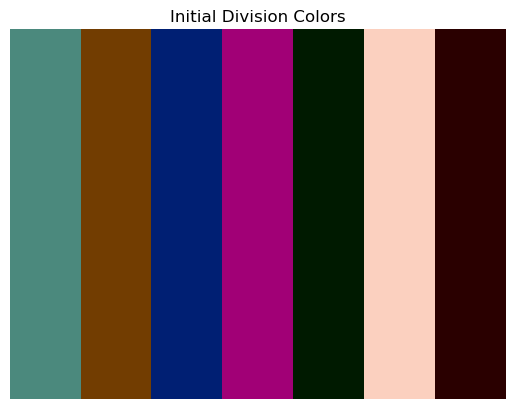

In [3]:
#Colors for Division hierarchy

#Load RGB colors to numpy array
initial_colors_rgb = np.loadtxt("/home/timothy/allen/division_transform_test/shift_scaled_rotated_colors_round1.txt")

#Normalize RGB (B/c skimage requires normalized RGB)
initial_colors_rgb_normalized = initial_colors_rgb/255.0

lab_color_initial = mf.RGB_arr_to_LAB_arr(initial_colors_rgb_normalized)
lab_color_initial = np.array(lab_color_initial)

#print(initial_colors_rgb_normalized)
print(lab_color_initial)

mf.plot_LAB_2D(lab_color_initial, colormath_obj=False, title="2D Initial Colors")
mf.plot_LAB_3D(lab_color_initial, colormath_obj=False, title="3D Initial Colors")
mf.plot_color_gradient(initial_colors_rgb_normalized, "Initial Division Colors")

Convex-Hull Algo (Shift to center)

- Found convex-hull
- Found centroid of convex-hull
- Centered ALL LAB values around centroid

[[ 53.08323116 -24.54621638 -10.87504743]
 [ 31.68375049  19.07052327  38.18328329]
 [ 16.7409008   26.41609996 -60.84740238]
 [ 36.38708541  63.21908967 -31.33930205]
 [  6.98897047 -14.50337408   9.61617819]
 [ 87.76229049  10.35797299  -1.95012745]
 [  4.56289487  19.66106436   7.00035203]]


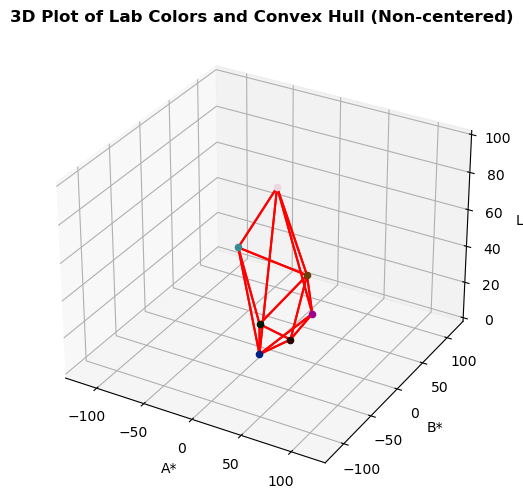

In [4]:
#Convert to skimage obj (RGB --> LAB)
hull = ConvexHull(lab_color_initial)
np.set_printoptions(suppress=True)
print(lab_color_initial[hull.vertices])
mf.plot_hull3D(lab_color_initial, "3D Plot of Lab Colors and Convex Hull (Non-centered)")

Centering the convex-hull
and converting to fake LAB space

In [5]:
lab_bounds = np.loadtxt("/home/timothy/allen/division_transform_test/valid_rgb_colors_in_lab/convex-hull-results/stepsize1_validLAB_in_RGB.txt")

In [6]:
#Centering all the LAB points around centroid

print("Original LAB Point: " , lab_color_initial[0])

#Center of convex-hull
centroid = np.mean(lab_color_initial[hull.vertices], axis=0)

print("Centroid of LAB Points:", centroid)

#Distance from center of LAB points to center of valid LAB Bounds

centroid_bounds = np.mean(lab_bounds, axis=0)

origin_to_centroid = centroid - centroid_bounds

print("Distance from origin to centroid of valid LAB Bounds", origin_to_centroid)

#Center all points at center of valid LAB space
shifted_lab = lab_color_initial - origin_to_centroid

print("Shifted LAB Colors to centroid of valid LAB Bounds:" , shifted_lab[0])

shifted_lab[:, 0] -= 50

print("Converted transformed points to Fake LAB Space:",shifted_lab[0])

Original LAB Point:  [ 53.08323116 -24.54621638 -10.87504743]
Centroid of LAB Points: [33.88701767 14.23930854 -7.17315226]
Distance from origin to centroid of valid LAB Bounds [-29.11298233  20.08930854  -2.02315226]
Shifted LAB Colors to centroid of valid LAB Bounds: [ 82.19621349 -44.63552492  -8.85189517]
Converted transformed points to Fake LAB Space: [ 32.19621349 -44.63552492  -8.85189517]


In [7]:
#assumes you're in fake LAB

def rotate_and_scale_points(points):
    
    #Rotation matrix
    def rotation_matrix(axis, theta):
        """
        Return the rotation matrix associated with counterclockwise rotation about
        the given axis by theta radians.
        """
        
        axis = np.asarray(axis)
        axis = axis / np.sqrt(np.dot(axis, axis)) #Normalize axis
        a = np.cos(theta / 2.0)
        b, c, d = -axis * np.sin(theta / 2.0)
        aa, bb, cc, dd = a * a, b * b, c * c, d * d
        bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
        return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                         [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                         [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

    def is_valid_lab_and_rgb(lab_points):
        
        lab_points = np.copy(lab_points)
        # Convert to real lab space for checking
        lab_points[:, 0] = (lab_points[:, 0] + 50)
        
        #Check for valid LAB values in fake LAB space
        if np.any(lab_points[:, 0] > 100) or \
           np.any(lab_points[:,0] < 0) or \
           np.any(np.abs(lab_points[:, 1]) > 128) or \
           np.any(np.abs(lab_points[:, 2]) > 128):
            return False
        
        for point in lab_points:
            lab_color = LabColor(lab_l=point[0], lab_a=point[1], lab_b=point[2])
            rgb_color = convert_color(lab_color, sRGBColor, target_illuminant='d50', observer='2')  # Convert LAB to RGB
            # If clamped values differ from original, the color was out of sRGB bounds
            if rgb_color.rgb_r < 0 or rgb_color.rgb_r > 1 or rgb_color.rgb_g < 0 or rgb_color.rgb_g > 1 or rgb_color.rgb_b < 0 or rgb_color.rgb_b > 1:
                return False

        return True

    def auto_scale_lab_colors(LAB_color_array):
        LAB_color_array = np.copy(LAB_color_array)
        last_valid_scale = 1.0
        for scale_factor in np.arange(1.0, 7.0, 0.1):  # Adjust scale range and step as needed
            scaled_points = np.copy(LAB_color_array) * scale_factor  # Scale a copy of the array
            if is_valid_lab_and_rgb(scaled_points):        
                last_valid_scale = scale_factor
            else:
                break
        return np.copy(LAB_color_array) * last_valid_scale  # Return a scaled copy

    best_volume = 0
    best_points = None

    # Rotate points around x, y, and z axes
    for theta_x, theta_y, theta_z in itertools.product(np.linspace(0, 2 * np.pi, 360), repeat=3):
        # Rotate points around x-axis
        rotated_points_x = np.dot(np.copy(points), rotation_matrix([1, 0, 0], theta_x))
        # Rotate points around y-axis
        rotated_points_y = np.dot(rotated_points_x, rotation_matrix([0, 1, 0], theta_y))
        # Rotate points around z-axis
        rotated_points = np.dot(rotated_points_y, rotation_matrix([0, 0, 1], theta_z))

        # Check if initially rotated points are valid in both LAB and RGB spaces
        if not is_valid_lab_and_rgb(rotated_points):
            continue

        # Scale rotated points
        scaled_points = auto_scale_lab_colors(rotated_points)

        try:
            # Calculate the volume of the convex hull of the scaled points
            hull = ConvexHull(scaled_points)
            volume = hull.volume
            
            if volume > best_volume:
                best_volume = volume
                best_points = np.copy(scaled_points)
                print("New best volume:", best_volume)
        except scipy.spatial.qhull.QhullError:
            # If points do not form valid convex hull
            # For example, if all points are collinear or coplanar in 3D space.
            continue

    return best_points

print("Rotating and Shifting")
optimized_points = rotate_and_scale_points(shifted_lab)
optimized_points[:, 0] += 50
print(optimized_points)
np.savetxt("/home/timothy/allen/division_transform_test/round2colors_2axes.txt", optimized_points)

Rotating and Shifting
New best volume: 145310.4386778755
New best volume: 145310.43867787556
New best volume: 145310.4386778756
New best volume: 193408.19388025242
New best volume: 193408.19388025245
New best volume: 193408.19388025248
New best volume: 251096.4380353691
New best volume: 251096.43803536912
New best volume: 251096.43803536918
New best volume: 251096.4380353692
New best volume: 319247.0337752927
New best volume: 319247.03377529274
New best volume: 319247.0337752928
New best volume: 319247.03377529286
New best volume: 319247.0337752929


KeyboardInterrupt: 

In [8]:
round2colors = np.loadtxt("/home/timothy/allen/division_transform_test/round2colors_2axes.txt")

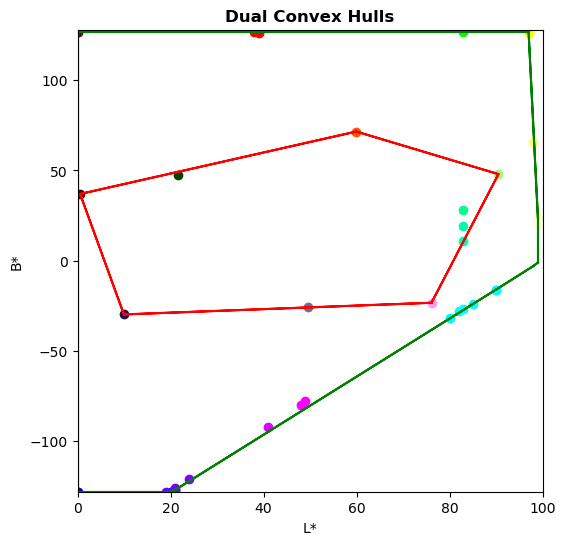

In [11]:
mf.plot_dual_hull2D(round2colors, lab_bounds, axes=('l','b'))

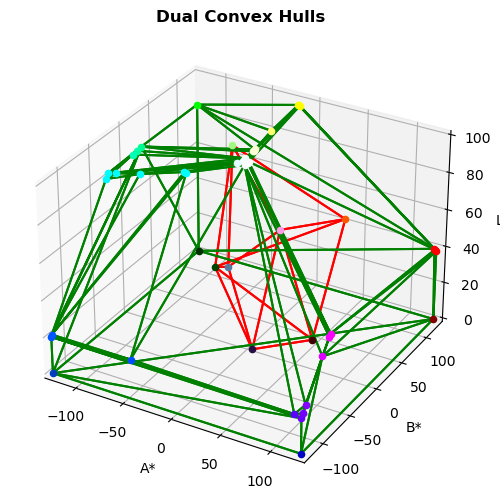

In [12]:
mf.plot_dual_hull3D(round2colors, lab_bounds)

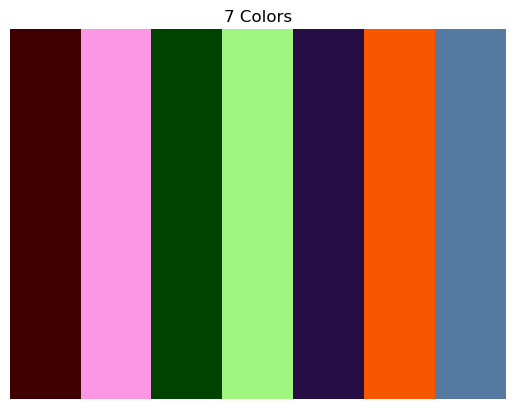

[[0.24581364 0.         0.        ]
 [0.99839791 0.60217699 0.91098759]
 [0.         0.26506405 0.        ]
 [0.63616663 0.97705079 0.51127816]
 [0.14967086 0.05737543 0.26905895]
 [0.97872106 0.3423583  0.        ]
 [0.33443273 0.47610693 0.63163379]]


In [18]:
round2colors_rgb = mf.lab_to_rgb(round2colors)
mf.plot_color_gradient(round2colors_rgb)
print(round2colors_rgb)
np.savetxt("/home/timothy/allen/division_transform_test/round2colors_rgb.txt", round2colors_rgb)

In [ ]:
mf.plot_color_gradient()